In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import plotly.graph_objects as go
import ipywidgets as widgets

In [38]:
def calculate_fft(csv_file, sampling_rate):
    # Carica i dati dal file CSV
    data = np.loadtxt(csv_file, delimiter=',', skiprows=1)  # Sostituisci con il tuo file CSV
    
    #sonda1 = data[:, 0]
    #sonda2 = data[:, 1]

    # Calcola la FFT
    N = len(data)
    fft_values = fft(data)
    fft_freqs = fftfreq(N, 1/sampling_rate)

    # Ritorna i valori della FFT e le frequenze
    return fft_values, fft_freqs
    

In [39]:
sampling_rate = 16e6
# Dizionari per memorizzare i risultati delle FFT
fft_results = {}

files = ['noFiltro.csv', 'filtro.csv','filtro2k2.csv','filtro5k.csv','filtro10k.csv']  # Lista dei file CSV da analizzare

# Ciclo per fare il calcolo FFT per ogni file
for file in files:
    fft_amplitude, fft_freqs = calculate_fft(file, sampling_rate)
    fft_results[file] = {
        'amplitude': fft_amplitude,
        'frequencies': fft_freqs
    }
    

In [42]:
def db_and_mask(fft_values,fft_freqs, freq_min, freq_max):
    fft_amp = np.abs(fft_values)
    fft_amp_db = 20 * np.log10(fft_amp)
    
    # Limita le frequenze tra 0 e 1 kHz
    mask = (fft_freqs >= freq_min) & (fft_freqs <= freq_max)

    # Applica la maschera sia alle ampiezze che alle frequenze
    fft_amp_db_filtered = fft_amp_db[mask]
    fft_freqs_filtered = fft_freqs[mask]

    return fft_amp_db_filtered, fft_freqs_filtered

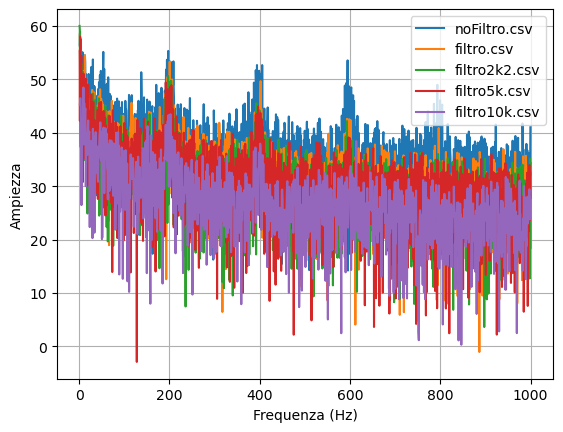

In [46]:
freq_min = 1
freq_max = 1000

for file in files:
    # Estrai i dati dal dizionario
    fft_amplitude = fft_results[file]['amplitude']
    fft_freqs = fft_results[file]['frequencies']
    fft_amplitude_db, fft_freqs_range = db_and_mask(fft_amplitude, fft_freqs,freq_min,freq_max)

    # Plot di ogni FFT
    plt.plot(fft_freqs_range, fft_amplitude_db, label=file)

# Configurazione del grafico
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Ampiezza')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Crea una figura
fig = go.Figure()

for file in files:
    fft_amplitude = fft_results[file]['amplitude']
    fft_freqs = fft_results[file]['frequencies']
    fft_amplitude_db, fft_freqs_range = db_and_mask(fft_amplitude, fft_freqs,freq_min,freq_max)
    fig.add_trace(go.Scatter(x=fft_freqs_range, y=fft_amplitude_db, mode='lines', name=file))

# Aggiungi una linea di riferimento a -3 dB
fig.add_shape(type="line",
              x0=1, x1=1000,  # Intervallo sull'asse X
              y0=-3, y1=-3,    # Linea orizzontale a -3 dB
              line=dict(color="Red", dash="dash"))

# Aggiungi titoli e etichette
fig.update_layout(
    title="Grafico FFT con possibilità di attivare/disattivare curve",
    xaxis_title="Frequenza (Hz)",
    yaxis_title="Ampiezza (dB)",
    showlegend=True,
    height=800,  # Imposta l'altezza del grafico (800 pixel)
    width=1000   # Imposta la larghezza del grafico (1000 pixel)
    #hovermode="x",  # Attiva il movimento della linea in corrispondenza del mouse lungo l'asse X
    #xaxis=dict(
    #    showspikes=True,  # Mostra le spike line verticali
    #    spikecolor="green",  # Colore della spike line
    #    spikethickness=2,  # Spessore della spike line
    #    spikedash="dot",  # Stile della linea (ad es., 'dot', 'dash')
    #    spikesnap="cursor",  # La spike line segue il cursore del mouse
    #    spikemode="across"  # La linea si estende attraverso tutto il grafico
    #)
)

# Mostra il grafico interattivo
fig.show()

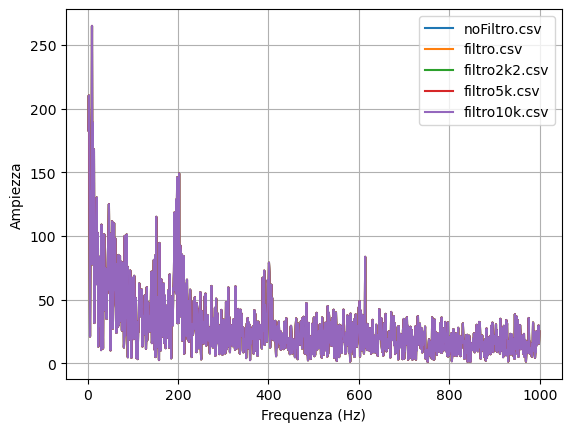

In [25]:
# Funzione per disegnare i plot
def plot_interactive(files):
    fig, ax = plt.subplots()
    
    # Crea una lista di linee vuote (verrà popolata con i dati dei file)
    lines = []
    for file in files:
        line, = ax.plot(fft_freqs_range, fft_amplitude_db, label=file)
        lines.append(line)
    
    plt.xlabel('Frequenza (Hz)')
    plt.ylabel('Ampiezza')
    plt.legend()
    plt.grid(True)
    
    # Crea widget di controllo
    checkboxes = [widgets.Checkbox(value=True, description=file) for file in files]
    
    def update(change):
        for checkbox, line in zip(checkboxes, lines):
            line.set_visible(checkbox.value)
        fig.canvas.draw_idle()
    
    for checkbox in checkboxes:
        checkbox.observe(update, 'value')
    
    # Mostra i widget
    return widgets.VBox(checkboxes)

# Esegui la funzione
plot_interactive(files)